In [1]:
#!pip install yfinance numpy pandas matplotlib scikit-learn tensorflow

In [95]:
import yfinance as yf
import pandas as pd

# List of ticker symbols for the top 5 Indian IT companies
tickers = ['TCS.NS', 'INFY.NS', 'WIPRO.NS', 'HCLTECH.NS', 'TECHM.NS']

# Download the historical data (adjust start and end dates as needed)
data_dict = {}
for ticker in tickers:
    data_dict[ticker] = yf.download(ticker, start='2010-01-01', end='2025-01-01')

# Print the first few rows of Tata Consultancy Services (TCS) stock data to check
print(data_dict['TCS.NS'].head())
#print(data_dict['INFY.NS'].head())
#print(data_dict['WIPRO.NS'].head())
#print(data_dict['HCLTECH.NS'].head())
#print(data_dict['TECHM.NS'].head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Price        Adj Close       Close        High         Low        Open  \
Ticker          TCS.NS      TCS.NS      TCS.NS      TCS.NS      TCS.NS   
Date                                                                     
2010-01-04  288.825470  375.825012  379.450012  374.524994  377.399994   
2010-01-05  288.902374  375.924988  379.774994  373.274994  377.500000   
2010-01-06  282.369995  367.424988  376.100006  366.500000  375.924988   
2010-01-07  274.511932  357.200012  369.700012  355.500000  367.750000   
2010-01-08  268.901855  349.899994  359.250000  348.250000  358.000000   

Price        Volume  
Ticker       TCS.NS  
Date                 
2010-01-04  1963682  
2010-01-05  2014488  
2010-01-06  3349176  
2010-01-07  6474892  
2010-01-08  6048178  


**Preprocess Data We will now preprocess the data by scaling the closing price and preparing the data for the LSTM model (using 60 previous days' data to predict the next day's closing price).**


In [96]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Preprocess the stock data for each company
scaler = MinMaxScaler(feature_range=(0, 1))

def preprocess_data(df, time_step=60):
    
    close_data = df['Close'].values.reshape(-1, 1)  # Using 'Close' column
    close_scaled = scaler.fit_transform(close_data)
    
    # Prepare sequences of data for LSTM
    X, y = [], []
    for i in range(len(close_scaled) - time_step - 1):
        X.append(close_scaled[i:(i + time_step), 0])
        y.append(close_scaled[i + time_step, 0])
    
    X = np.array(X)
    y = np.array(y)
    
    # Reshape X to be compatible with LSTM input
    X = X.reshape(X.shape[0], X.shape[1], 1)
    
    return X, y, close_scaled



# Create data for all companies
company_data = {}
for ticker, df in data_dict.items():
    X, y, scaled_data = preprocess_data(df)
    company_data[ticker] = (X, y, scaled_data)

# Check the shape of data for one of the companies
print(f"Company 1 X shape: {company_data['TCS.NS'][0].shape}")
print(f"Company 1 y shape: {company_data['TCS.NS'][1].shape}")


Company 1 X shape: (3639, 60, 1)
Company 1 y shape: (3639,)


**Split Data into Training and Testing We will now split the data into training (80%) and testing (20%) for each company.**

In [97]:
# Split the data into training and testing sets
train_data = {}
test_data = {}

for ticker, (X, y, scaled_data) in company_data.items():
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    train_data[ticker] = (X_train, y_train)
    test_data[ticker] = (X_test, y_test)

# Check the shape of training data for one company
print(f"Company 1 X_train shape: {train_data['TCS.NS'][0].shape}")
print(f"Company 1 y_train shape: {train_data['TCS.NS'][1].shape}")


Company 1 X_train shape: (2911, 60, 1)
Company 1 y_train shape: (2911,)


**Build the LSTM Model We will now create an LSTM model for each company using the same architecture as before.**


In [98]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Function to create and compile the LSTM model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Output layer
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train the model for each company
models = {}
history_dict = {}

for ticker in tickers:
    X_train, y_train = train_data[ticker]
    X_test, y_test = test_data[ticker]
    
    # Create and compile the LSTM model
    model = create_lstm_model((X_train.shape[1], 1))
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=80, batch_size=16, validation_data=(X_test, y_test), verbose=1)
    
    models[ticker] = model
    history_dict[ticker] = history

# Example of checking model training history
print(f"Training history for {tickers[0]}: {history_dict[tickers[0]]}")


Epoch 1/80


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0174 - val_loss: 0.0023
Epoch 2/80
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 3/80
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.5797e-04 - val_loss: 0.0010
Epoch 4/80
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.8079e-04 - val_loss: 8.6050e-04
Epoch 5/80
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.4358e-04 - val_loss: 0.0011
Epoch 6/80
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.7816e-04 - val_loss: 0.0023
Epoch 7/80
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.1145e-04 - val_loss: 9.0410e-04
Epoch 8/80
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.5452e-04 - val_loss: 7.8882e-04
Epoch 9/80
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.3323e-04 - val_loss: 0.0035
Epoch 10/80
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.0181e-04 - val_loss: 8.5556e-04
Epoch 11/80
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.8249e-04 - val_loss: 5.7028e-04
Epoch 1

**Make Predictions and Visualize Results After training, you can make predictions and visualize the predicted vs actual stock prices for each company.**

In [14]:
X_train.shape

(2911, 60, 1)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


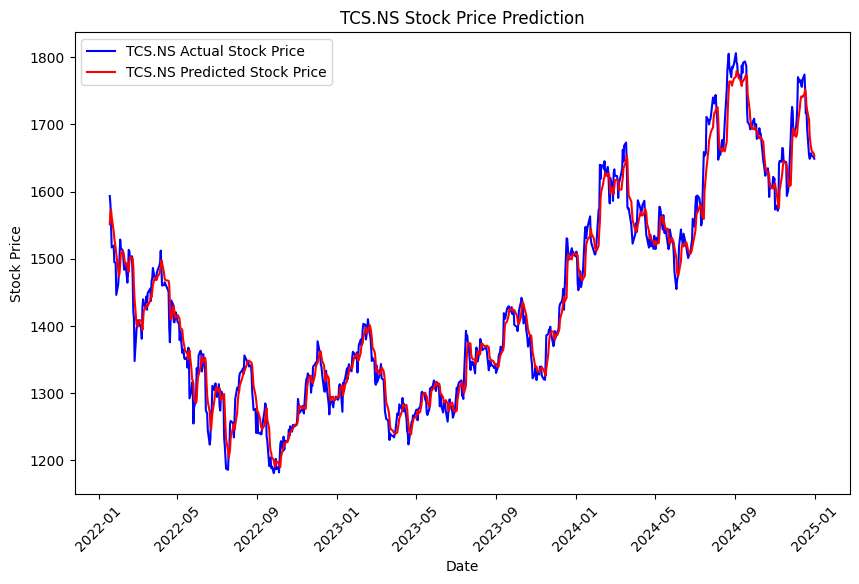

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


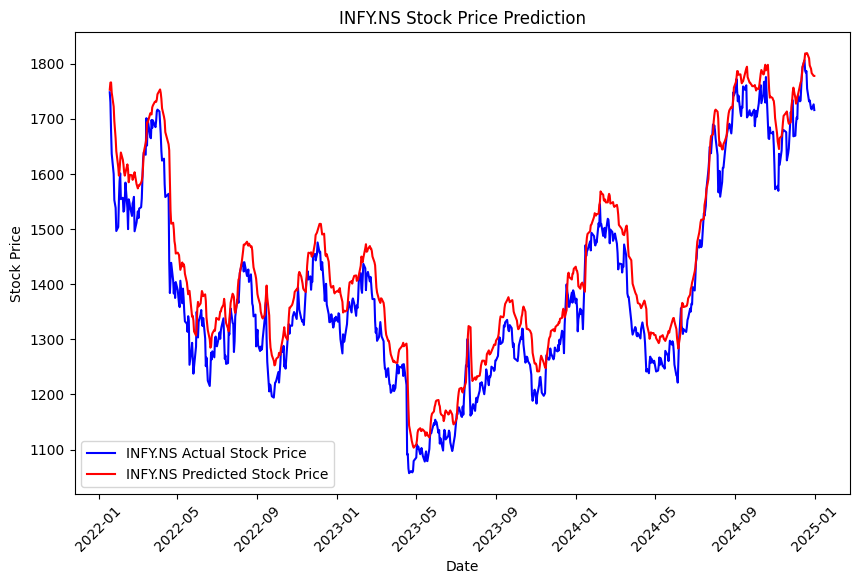

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


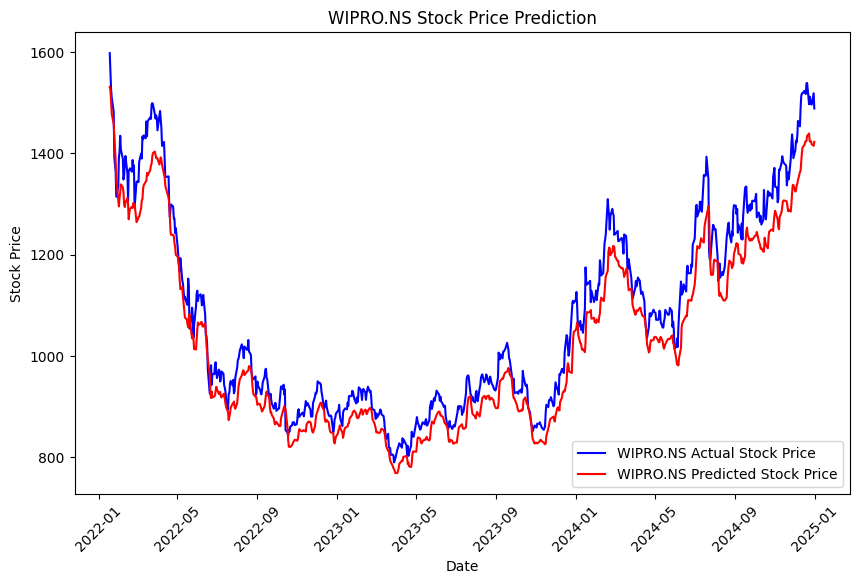

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


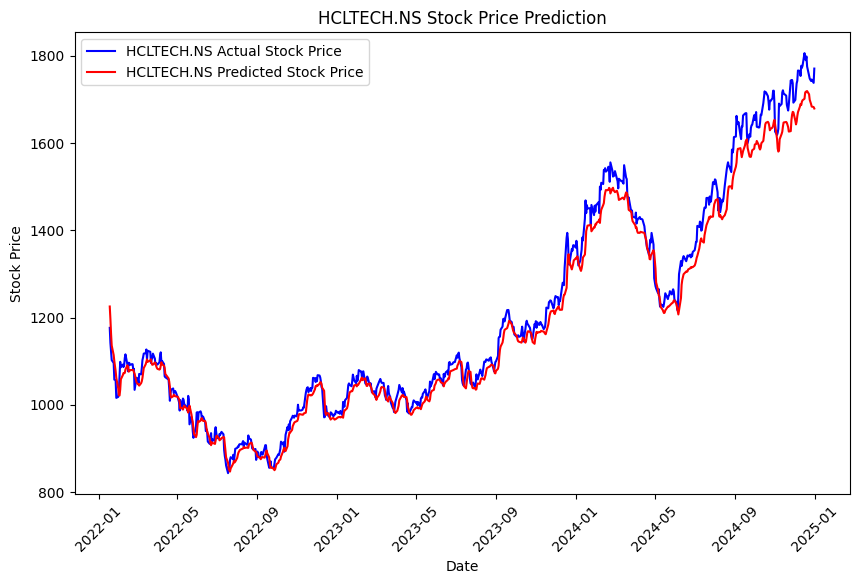

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


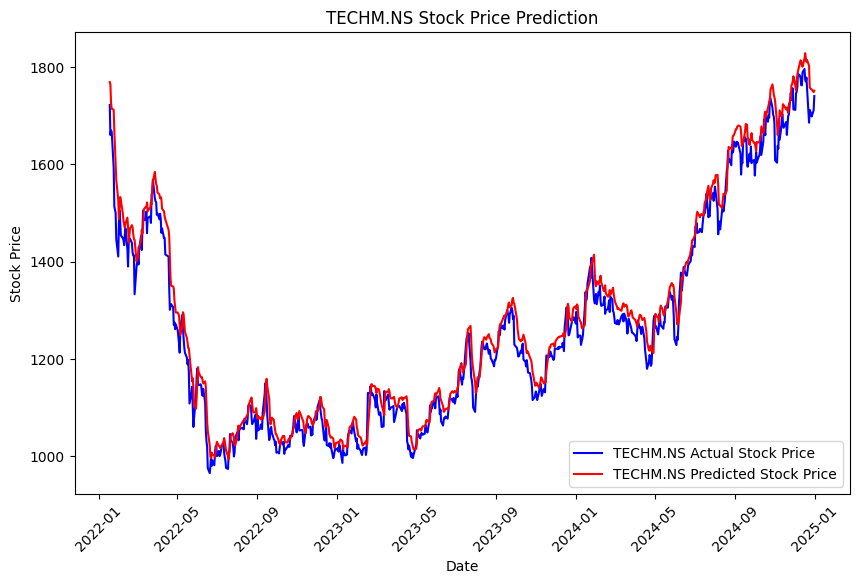

In [99]:
import matplotlib.pyplot as plt

# Make predictions and visualize results
predictions_dict = {}

for ticker, model in models.items():
    X_test, y_test = test_data[ticker]
    
    # Make predictions on the test set
    predicted_stock_price = model.predict(X_test)
    
    # Inverse transform the predicted values and true values
    predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
    actual_stock_price = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    
    # Get the dates corresponding to the test data
    test_dates = data_dict[ticker].iloc[-len(y_test):].index  # Use the index (date) of the last n rows
    
    # Save predictions for visualization
    predictions_dict[ticker] = (predicted_stock_price, actual_stock_price)
    
    # Plot the actual vs predicted stock prices
    plt.figure(figsize=(10, 6))
    plt.plot(test_dates, actual_stock_price, color='blue', label=f'{ticker} Actual Stock Price')
    plt.plot(test_dates, predicted_stock_price, color='red', label=f'{ticker} Predicted Stock Price')
    plt.title(f'{ticker} Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()


In [115]:
from sklearn.metrics import mean_squared_error, r2_score
import math

# Initialize dictionaries to store evaluation metrics
evaluation_metrics = {}

for ticker, model in models.items():
    X_test, y_test = test_data[ticker]
    
    # Make predictions on the test set
    predicted_stock_price = model.predict(X_test)
    
    # Inverse transform the predicted values and true values
    predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
    actual_stock_price = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Calculate evaluation metrics
    mse = mean_squared_error(actual_stock_price, predicted_stock_price)/1000
    rmse = math.sqrt(mse)/1000
    r2 = r2_score(actual_stock_price, predicted_stock_price)
    
    # Store the metrics in a dictionary
    evaluation_metrics[ticker] = {'MSE': mse, 'RMSE': rmse, 'R2': r2}
    
    # Print the evaluation results for each company
    print(f"{ticker} - MSE: {mse:.4f}, R2: {r2:.4f}, RMSE: {rmse:.4f}")

# Example: Checking evaluation metrics for TCS
print(f"Evaluation metrics for TCS.NS: {evaluation_metrics['TCS.NS']}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
TCS.NS - MSE: 0.5691, R2: 0.9770, RMSE: 0.0008
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
INFY.NS - MSE: 3.3285, R2: 0.8980, RMSE: 0.0018
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
WIPRO.NS - MSE: 3.1432, R2: 0.9192, RMSE: 0.0018
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
HCLTECH.NS - MSE: 1.2700, R2: 0.9801, RMSE: 0.0011
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
TECHM.NS - MSE: 1.2762, R2: 0.9729, RMSE: 0.0011
Evaluation metrics for TCS.NS: {'MSE': 0.5690811136334125, 'RMSE': 0.0007543746507097203, 'R2': 0.977025654631556}


In [113]:
avgR2=0
c=0
for ticker, model in models.items():
    avgR2+=evaluation_metrics[ticker]['R2']
    c+=1
print("Avg R2: ", round(avgR2/c,4))

Avg R2:  0.9494
